<a href="https://colab.research.google.com/github/LindholmLabs/Neural-Computing/blob/main/CS4287_Prj1_24293059_24273759_24284335.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lars Jacobs (24293059)
William Lindholm (24273759)
Patrick Vorreiter (24284335)



# Project 1 notes
-----------------

## Data Set

Skin cancer dataset. This dataset contains 1800 pictures of benign cell pictures and 1500 pictures of malignant cell pictures

## Pre-processing

This will be resizing and flipping the pictures randomly to improve the models generalization. Maybe grayscaling and exposure settings that can also be changed

## Network and hyperparameters

Probably this will be most work. Figuring out which network setup works best and makes most sense. Lots of research needed here to know what kind of layers and how big / how much of them to use.

## Loss Function

Try different loss functions and try to explain why some work better than others:
- MSE
- Cross entropy
- DICE


## Optimiser

Try different optimisers and try to explain why some work better than others:
- SGD
- ADAM


## Cross Fold Validation

Basically just use it, maybe 5 or 10 fold if needed

## Results

Display different kinds of metrics. For classification of our dataset we can use terms like FPR, TPR, precision, recall, accuracy, etc. Make a confusion matrix, stuff like that

## Evaluation

Try to see if we overfitted or underfitted the data. Not sure how to do this yet but we can figure it out.

## Experiments

Experiments with number of layers and what kind of layers for example. It will be crucial here to keep our notebook clean and make use of the code blocks in the notebook so we dont have to rerun all the code for different experiments.

**Loading the dataset**

In [ ]:
# Needed libraries
!pip install kaggle;

from google.colab import files

files.upload()

! mkdir ~/.kaggle;
! cp kaggle.json ~/.kaggle/;
! chmod 600 ~/.kaggle/kaggle.json;
! kaggle datasets list
! kaggle datasets download -d rm1000/skin-cancer-isic-images;
! unzip skin-cancer-isic-images.zip;



Saving kaggle.json to kaggle.json
ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           7604        139  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                         94KB  2024-09-02 10:53:57          35989        636  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                        22KB  2024-10-06 11:27:38           3806         80  1.0              
mohamedyosef101/2024-olympics-medals-and-econo

**Importing Data**

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path for your dataset
benign_path = './benign'
malignant_path = './malignant'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        images.append(img)
    return images

# Load benign and malignant images
benign_images = load_images_from_folder(benign_path)
malignant_images = load_images_from_folder(malignant_path)


**Visualization**

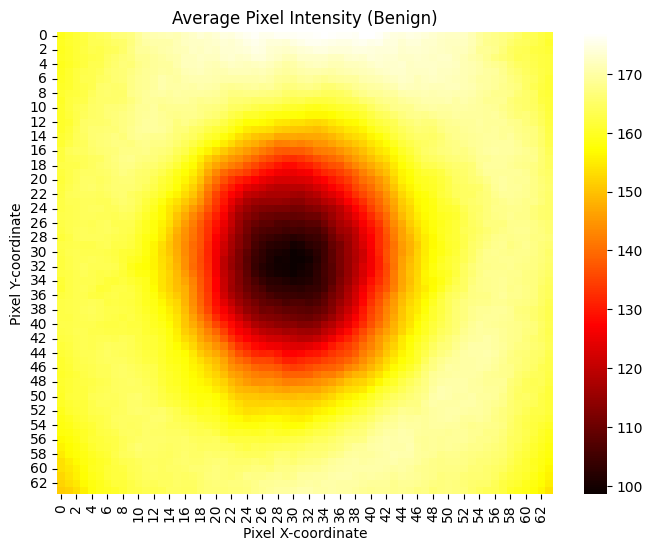

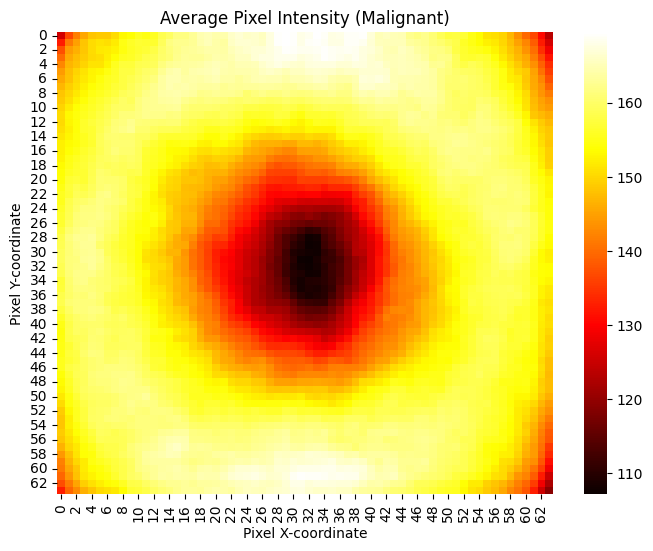

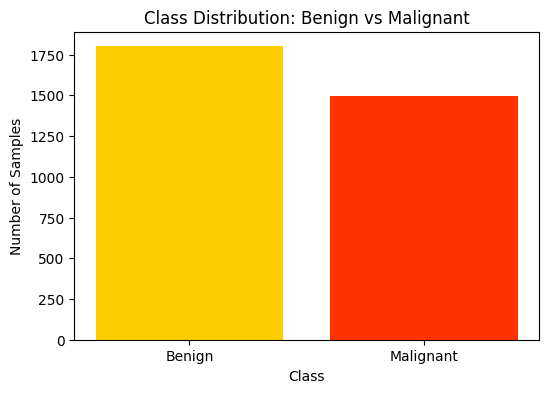

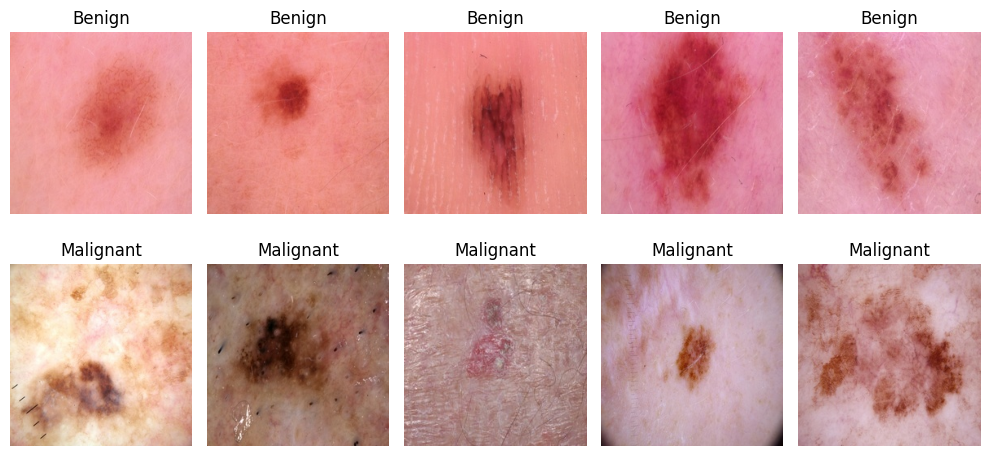

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

def compute_average_pixel_intensity(images, target_size=(64, 64)):
    avg_intensity = np.zeros(target_size)
    for img in images:
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized.convert('L'))
        avg_intensity += img_array
    avg_intensity /= len(images)
    return avg_intensity

benign_sampled = random.sample(benign_images, min(100, len(benign_images)))
malignant_sampled = random.sample(malignant_images, min(100, len(malignant_images)))

avg_intensity_benign = compute_average_pixel_intensity(benign_sampled)
avg_intensity_malignant = compute_average_pixel_intensity(malignant_sampled)

plt.figure(figsize=(8, 6))
sns.heatmap(avg_intensity_benign, cmap='hot', cbar=True)
plt.title("Average Pixel Intensity (Benign)")
plt.xlabel('Pixel X-coordinate')
plt.ylabel('Pixel Y-coordinate')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(avg_intensity_malignant, cmap='hot', cbar=True)
plt.title("Average Pixel Intensity (Malignant)")
plt.xlabel('Pixel X-coordinate')
plt.ylabel('Pixel Y-coordinate')
plt.show()

num_benign = len(benign_images)
num_malignant = len(malignant_images)
colors = ['#ffcc00', '#ff3300']

plt.figure(figsize=(6, 4))
plt.bar(['Benign', 'Malignant'], [num_benign, num_malignant], color=colors)
plt.title('Class Distribution: Benign vs Malignant')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(benign_images[i])
    plt.title('Benign')
    plt.axis('off')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(malignant_images[i])
    plt.title('Malignant')
    plt.axis('off')

plt.tight_layout()
plt.show()




# Our model class

--network structure
--Opimtizer
--Loss function
--Cross fold validation
--Explain what things we can change and which methods we will use for them

In [ ]:
from re import X
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ImageClassificationModel:
    def __init__(self, optimizer='adam', loss_function='binary_crossentropy', activation_function='relu', output_activation_function='sigmoid', num_output_neurons=1, batch_size=64, epochs=20, strides=(2, 2), dilation=(1, 1), data_augmentation=None, num_folds=2):
        # Fixed parameters
        self.img_size = (228, 228)
        self.num_classes = 2
        self.test_size = 0.2
        self.val_size = 0.1

        # Customizable parameters
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.activation_function = activation_function
        self.batch_size = batch_size
        self.epochs = epochs
        self.output_activation_function = output_activation_function
        self.data_augmentation = data_augmentation
        self.model_summary = False
        self.training_progress = 0
        self.num_output_neurons = num_output_neurons
        self.strides = strides
        self.dilation = dilation
        self.num_folds = num_folds

    def show_model_summary(self):
        self.model_summary = True

    def show_training_progress(self):
        self.training_progress = 1

    # Function to resize and normalize images
    def preprocess_images(self, images):
        images_resized = np.array([tf.image.resize(img, self.img_size).numpy() for img in images])
        images_resized = images_resized.astype('float32') / 255.0
        return images_resized

    # Function to load data, preprocess, and split into train, validation, and test sets
    def load_data(self, benign_images, malignant_images):
        benign_images_array = self.preprocess_images(benign_images)
        malignant_images_array = self.preprocess_images(malignant_images)

        benign_labels = np.zeros(len(benign_images_array))
        malignant_labels = np.ones(len(malignant_images_array))

        X_data = np.concatenate((benign_images_array, malignant_images_array), axis=0)
        y_data = np.concatenate((benign_labels, malignant_labels), axis=0)

        indices = np.arange(X_data.shape[0])
        np.random.shuffle(indices)
        X_data = X_data[indices]
        y_data = y_data[indices]

        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=self.test_size, random_state=42)

        if self.num_output_neurons != 1:
            y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
            y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        return X_train, y_train, X_test, y_test

    # Function to build the model
    def build_model(self, input_shape):
        model = models.Sequential()

        # Input layer
        model.add(layers.Input(shape=input_shape))

        # 1st block
        model.add(layers.Conv2D(32, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.2))

        # 2nd block
        model.add(layers.Conv2D(64, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.3))

        # 3rd block
        model.add(layers.Conv2D(128, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.4))

        # Dense layer
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation=self.activation_function))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_output_neurons, activation=self.output_activation_function))

        return model

    # Function to compile and train the model using the preset parameters
    def train_model(self, X_data, y_data):
        kf = KFold(n_splits=self.num_folds)
        fold_models = []
        fold_histories = []

        for fold, (train_index, val_index) in enumerate(kf.split(X_data)):
            X_train, X_val = X_data[train_index], X_data[val_index]
            y_train, y_val = y_data[train_index], y_data[val_index]

            model = self.build_model(X_train.shape[1:])

            model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

            if self.model_summary:
                model.summary()

            if self.data_augmentation:
                history = model.fit(self.data_augmentation.flow(X_train, y_train, batch_size=self.batch_size),
                                    epochs=self.epochs, validation_data=(X_val, y_val),
                                    verbose=self.training_progress)
            else:
                history = model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs,
                                    validation_data=(X_val, y_val), verbose=self.training_progress)

            # Store the model and history for this fold
            fold_models.append(model)
            fold_histories.append(history)

            # Optionally evaluate on the validation set
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        return fold_models, fold_histories  # Return lists of models and histories

    # Function to evaluate the model on test data
    def evaluate_model(self, models, X_test, y_test):
        """Evaluates the models and calculates performance metrics."""

        all_y_true = []
        all_y_pred = []

        # Loop through each model to get predictions
        for model in models:
            # For binary classification with sigmoid output:
            if self.num_output_neurons == 1:
                y_pred_prob = model.predict(X_test)
                y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (0 or 1)
                y_true = y_test  # No need to use argmax for binary classification
            # For multi-class classification with softmax output:
            else:
                y_pred_prob = model.predict(X_test)
                y_pred = np.argmax(y_pred_prob, axis=1)
                y_true = np.argmax(y_test, axis=1)

            # Store true and predicted labels
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

        # Convert to numpy arrays
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)

        # Calculate metrics
        accuracy = accuracy_score(all_y_true, all_y_pred)
        precision = precision_score(all_y_true, all_y_pred)
        recall = recall_score(all_y_true, all_y_pred)
        f1 = f1_score(all_y_true, all_y_pred)

        # Print the overall metrics
        print(f"\nOverall Metrics Across All Folds:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return all_y_true, all_y_pred  # Return concatenated true and predicted labels

    def run(self, evaluate_model=True, plot_history=True, print_confusion_matrix=True):
        # Load data and split into train, validation, and test sets
        X_train, y_train, X_test, y_test = self.load_data(benign_images, malignant_images)

        # Train the model with K-Fold cross-validation
        fold_models, fold_histories = self.train_model(X_train, y_train)

        if evaluate_model:
            # Evaluate the model using the evaluate_model method
            y_trues, y_preds = self.evaluate_model(fold_models, X_test, y_test)


        if plot_history:
            # Collect accuracy and loss across all folds
            all_training_acc = []
            all_validation_acc = []
            all_training_loss = []
            all_validation_loss = []

            for history in fold_histories:
                all_training_acc.append(history.history['accuracy'])
                all_validation_acc.append(history.history['val_accuracy'])
                all_training_loss.append(history.history['loss'])
                all_validation_loss.append(history.history['val_loss'])

            # Plot the combined history
            self.plot_combined_history(all_training_acc, all_validation_acc, all_training_loss, all_validation_loss)

        if print_confusion_matrix:
            # Print confusion matrix for the combined predictions
            self.print_confusion_matrix(y_trues, y_preds)


    # Function to plot training and validation accuracy and loss
    def plot_combined_history(self, all_training_acc, all_validation_acc, all_training_loss, all_validation_loss):
        # Get the number of epochs (assumes all folds have the same number of epochs)
        epochs_range = range(len(all_training_acc[0]))

        plt.figure(figsize=(12, 6))

        # Define a list of colors for consistency across plots
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # You can add more colors if you have more than 7 folds

        # Plot training and validation accuracy for all folds
        plt.subplot(1, 2, 1)
        for i, (acc, val_acc) in enumerate(zip(all_training_acc, all_validation_acc)):
            color = colors[i % len(colors)]  # Cycle through the list of colors
            plt.plot(epochs_range, acc, label=f'Fold {i+1} Training Accuracy', color=color)
            plt.plot(epochs_range, val_acc, label=f'Fold {i+1} Validation Accuracy', linestyle='--', color=color)
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        # Plot training and validation loss for all folds
        plt.subplot(1, 2, 2)
        for i, (loss, val_loss) in enumerate(zip(all_training_loss, all_validation_loss)):
            color = colors[i % len(colors)]  # Cycle through the list of colors
            plt.plot(epochs_range, loss, label=f'Fold {i+1} Training Loss', color=color)
            plt.plot(epochs_range, val_loss, label=f'Fold {i+1} Validation Loss', linestyle='--', color=color)
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.show()



    def print_confusion_matrix(self, y_true, y_pred):
        """Prints the confusion matrix."""
        conf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


# Experimentation
After implementing our model class, using the same architecture we found in lab 3 for the cifar-10 example. We decided to limit ourselves to not modifying the number of layers, or their sizes.

# Determining hyper parameters
We decided that the first thing to modify would be the optimizer and loss function. Especially since the code we borrowed from the cifar-10 example had an optimizer for a categorical dataset, meanwhile our dataset was binary; benign or malignan.


Thereafter we decided to add the option of easily changing the actication functions. But we did not want too much control, since we do not have enough compuing power to tune every parameter separatly. We decdided on grouping together all hidden layers, to one parameter, and the output layer as a separate paramter. This is since we may want to have 2 output neurons with softmax, but relus for all the hidden layers.


Due to our dataset consisting of relatively high resolution images, we wanted a way to effectively train larger features while maintaing small kernels, which is why we added the dilation parameter. But we also noticed that the training was still taking very long, so we decided to also be able to modify the stride.

We also determined that an image of a skin spot, may as well be flipped or taken slighly zoomed in, which is why we want to add the ability to add data augmentation, to facilitate this we simply pass

This has resulted in the following list of parameters that we will be able to tune easily in our model class:
- optimizer
- loss function
- hidden layers activation function
- output activation function
- number of output neurons
- batch size
- epochs
- strides
- dilation
- data augmentation



#**Results**


So not only we used the model structure provided by the lab of our module, we also start to test how the model performs with the configuration that was given to us. This will give us a baseline on which we can improve.



Fold 1 - Validation Loss: 0.4472, Validation Accuracy: 0.7827
Fold 2 - Validation Loss: 0.6685, Validation Accuracy: 0.6018
Fold 3 - Validation Loss: 0.4689, Validation Accuracy: 0.7440
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7121
Precision: 0.6319
Recall: 0.8419
F1 Score: 0.7220


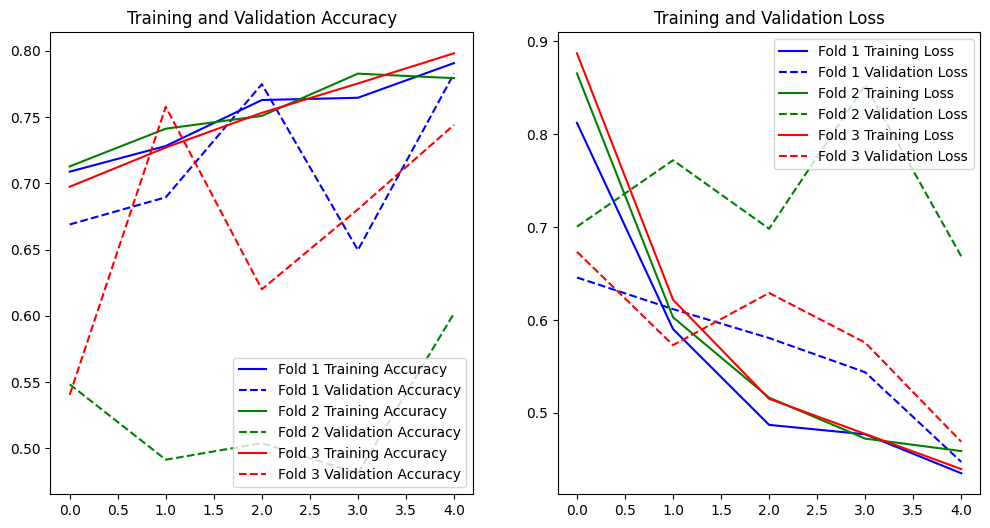

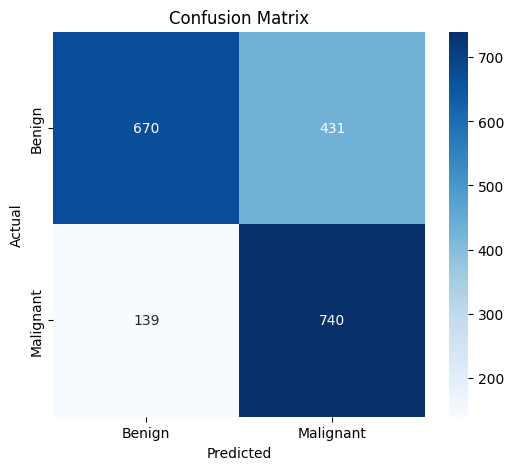

In [ ]:
model_obj = ImageClassificationModel(optimizer='RMSprop',
                                     loss_function='categorical_crossentropy',
                                     activation_function='relu',
                                     output_activation_function='softmax',
                                     batch_size=32,
                                     epochs=5,
                                     num_output_neurons=2,
                                     num_folds=3)
model_obj.run()

**Test Other Configurations**

Looking at the literature around the subject of CNN's, we found that:


*   Adam as optimizer is almost always the better choice
*   Binary cross entropy is the best choice for our binary classification problem
*   ReLu is the best activation function in most cases. We will test some different versions of this like leaky relu.

We will use these configuration options as default for the next tests. We will try different configurations by changing:

*   Batch size
*   Strides
*   Dilation
*   Data Augmentation



In [ ]:
TEST_OPTIMIZER = 'adam'
TEST_LOSS_FUNCTION = 'binary_crossentropy'
TEST_ACTIVATION_FUNCTION = 'relu'
TEST_EPOCHS = 25
TEST_FOLDS = 4

**Batch Size**

Equal to 16

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=16, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

KeyboardInterrupt: 

Fold 1 - Validation Loss: 0.3801, Validation Accuracy: 0.8091
Fold 2 - Validation Loss: 0.9296, Validation Accuracy: 0.6419
Fold 3 - Validation Loss: 0.4005, Validation Accuracy: 0.8042
Fold 4 - Validation Loss: 0.5292, Validation Accuracy: 0.7511
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7723
Precision: 0.6773
Recall: 0.8777
F1 Score: 0.7646


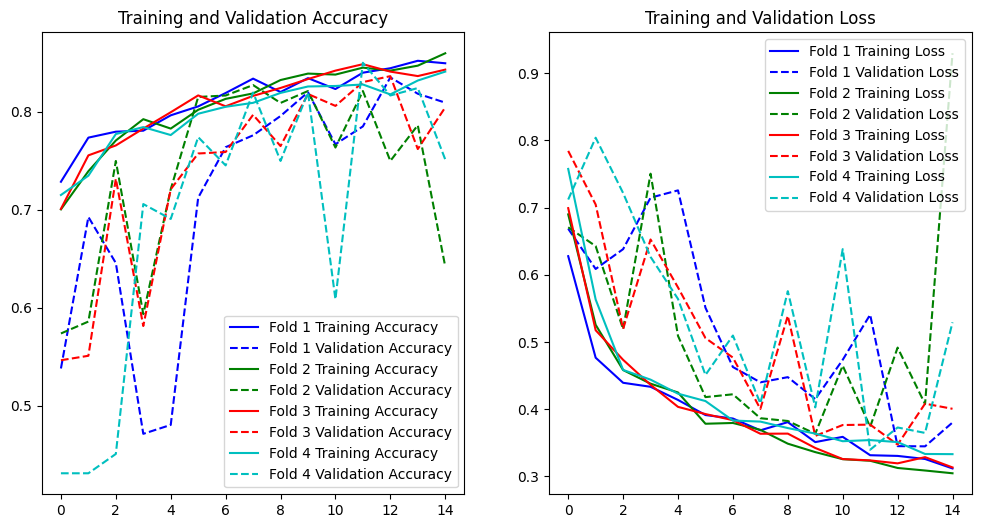

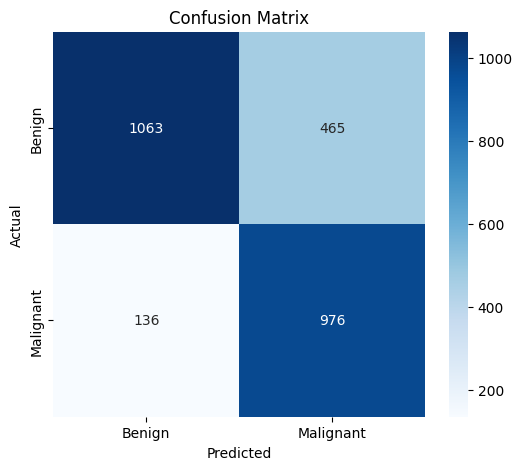

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=32, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

Equal to 64

Fold 1 - Validation Loss: 0.4097, Validation Accuracy: 0.8076
Fold 2 - Validation Loss: 0.3808, Validation Accuracy: 0.8164
Fold 3 - Validation Loss: 0.3732, Validation Accuracy: 0.8103
Fold 4 - Validation Loss: 0.3549, Validation Accuracy: 0.8437
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8098
Precision: 0.7492
Recall: 0.8503
F1 Score: 0.7966


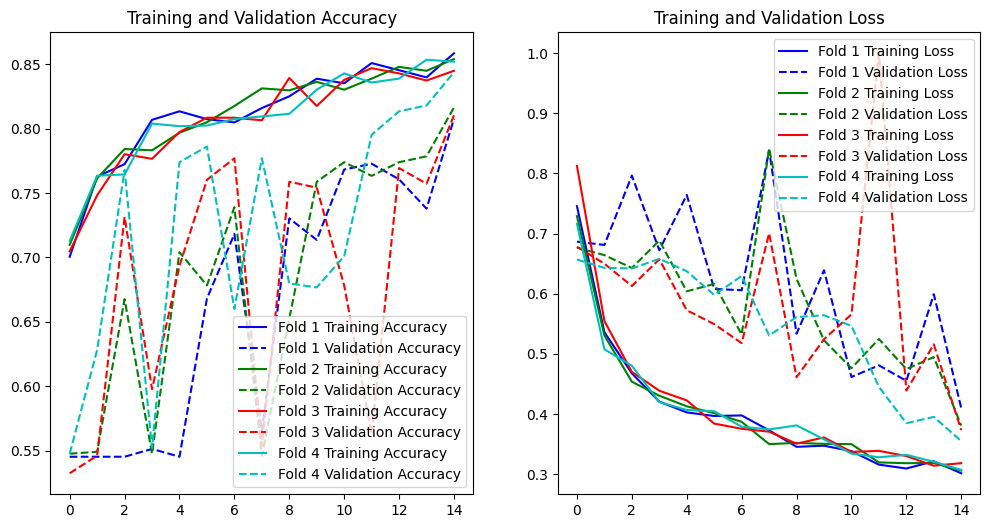

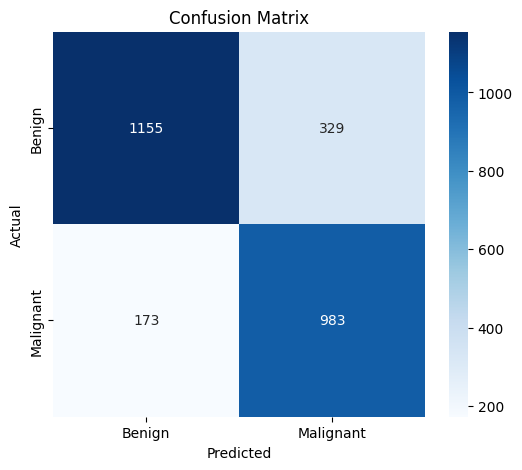

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=64, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

Equal to 128

Fold 1 - Validation Loss: 0.4870, Validation Accuracy: 0.7667
Fold 2 - Validation Loss: 1.0861, Validation Accuracy: 0.5797
Fold 3 - Validation Loss: 0.5576, Validation Accuracy: 0.6525
Fold 4 - Validation Loss: 0.4849, Validation Accuracy: 0.7572
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Overall Metrics Across All Folds:
Accuracy: 0.6697
Precision: 0.7821
Recall: 0.3687
F1 Score: 0.5011


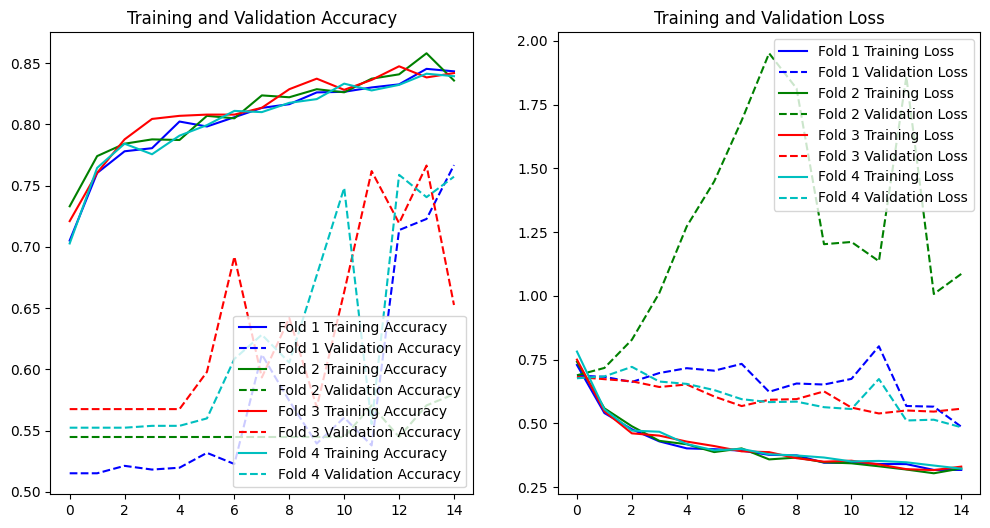

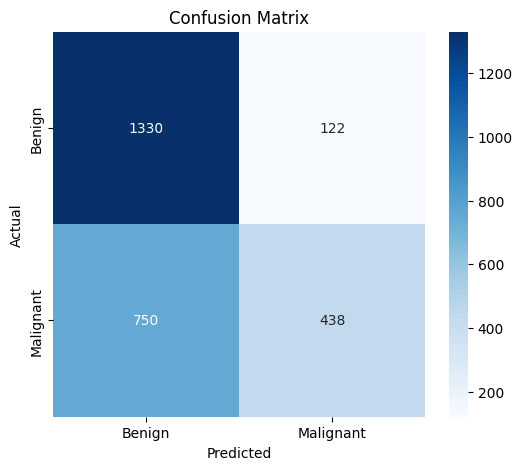

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=128, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

In [ ]:
TEST_BATCH_SIZE = 64

**Strides**



Fold 1 - Validation Loss: 0.3850, Validation Accuracy: 0.8348
Fold 2 - Validation Loss: 0.2927, Validation Accuracy: 0.8710
Fold 3 - Validation Loss: 0.3567, Validation Accuracy: 0.8513
Fold 4 - Validation Loss: 0.3608, Validation Accuracy: 0.8240
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8424
Precision: 0.8470
Recall: 0.7960
F1 Score: 0.8207


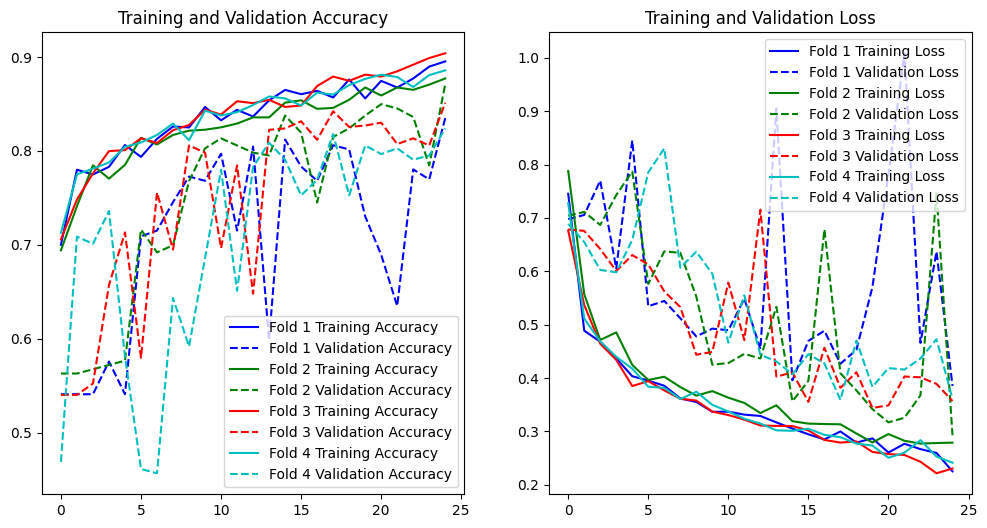

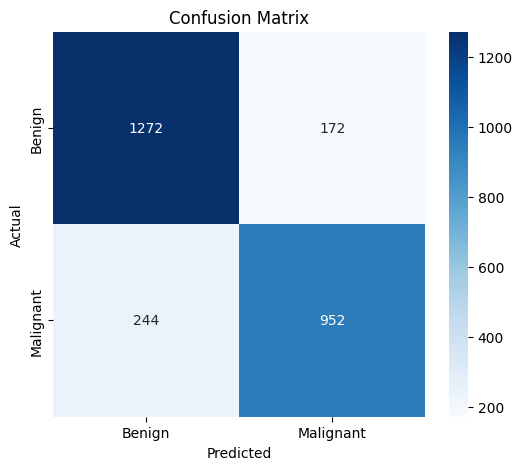

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(2, 2),
    num_folds=TEST_FOLDS)

model_obj.run()

Fold 1 - Validation Loss: 0.3199, Validation Accuracy: 0.8364
Fold 2 - Validation Loss: 0.4072, Validation Accuracy: 0.8316
Fold 3 - Validation Loss: 0.6887, Validation Accuracy: 0.8179
Fold 4 - Validation Loss: 0.5661, Validation Accuracy: 0.8088
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8106
Precision: 0.7622
Recall: 0.8636
F1 Score: 0.8097


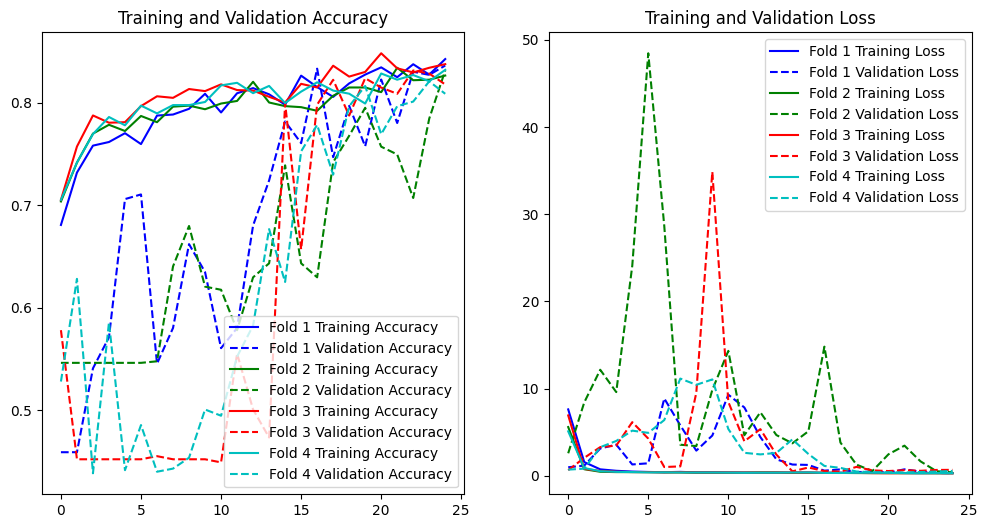

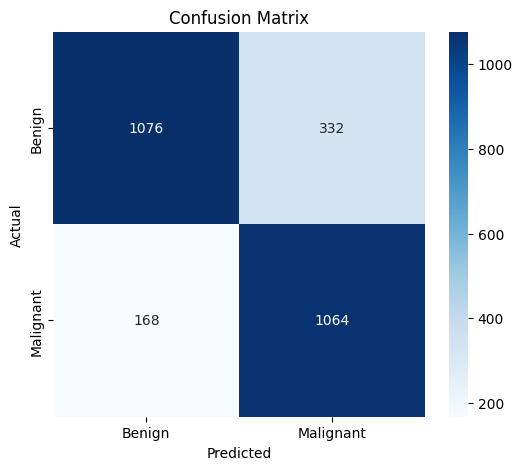

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(1, 1),
    num_folds=TEST_FOLDS)

model_obj.run()

In [ ]:
TEST_STRIDES = (2, 2)

**Dilation**


Fold 1 - Validation Loss: 0.4463, Validation Accuracy: 0.8061
Fold 2 - Validation Loss: 0.4534, Validation Accuracy: 0.8209
Fold 3 - Validation Loss: 0.3585, Validation Accuracy: 0.8240
Fold 4 - Validation Loss: 0.3916, Validation Accuracy: 0.8073
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8364
Precision: 0.8415
Recall: 0.7500
F1 Score: 0.7931


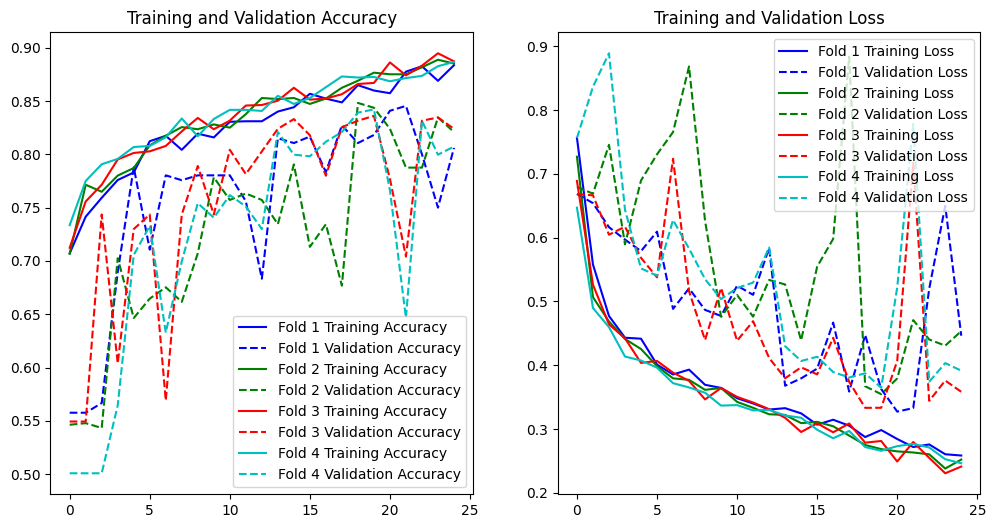

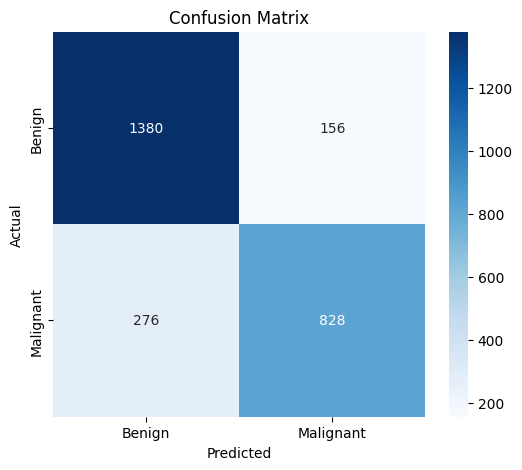

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=TEST_STRIDES,
    dilation=(1,1),
    num_folds=TEST_FOLDS)

model_obj.run()

Fold 1 - Validation Loss: 0.9458, Validation Accuracy: 0.7439
Fold 2 - Validation Loss: 0.4802, Validation Accuracy: 0.7375
Fold 3 - Validation Loss: 0.9969, Validation Accuracy: 0.8042
Fold 4 - Validation Loss: 0.9420, Validation Accuracy: 0.7602
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7989
Precision: 0.7290
Recall: 0.8754
F1 Score: 0.7955


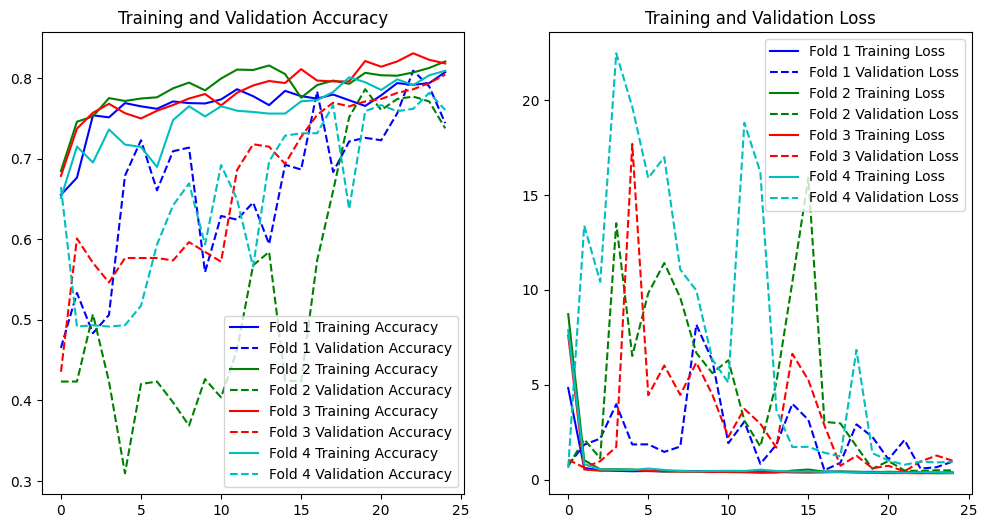

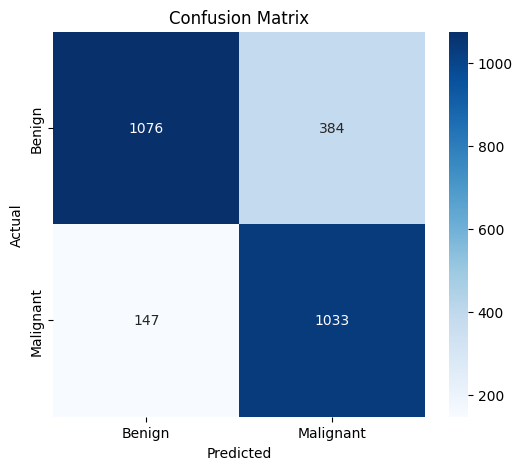

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(1,1),
    dilation=(2,2),
    num_folds=TEST_FOLDS)

model_obj.run()

**Pre Processing Testing**

### Testing Leaky relus

Epoch 1/15
42/42 [==============================] - 18s 370ms/step - loss: 0.7436 - accuracy: 0.7011 - val_loss: 0.6683 - val_accuracy: 0.6368
Epoch 2/15
42/42 [==============================] - 15s 345ms/step - loss: 0.6169 - accuracy: 0.7352 - val_loss: 0.6431 - val_accuracy: 0.7354
Epoch 3/15
42/42 [==============================] - 15s 347ms/step - loss: 0.5267 - accuracy: 0.7534 - val_loss: 0.5994 - val_accuracy: 0.6748
Epoch 4/15
42/42 [==============================] - 14s 341ms/step - loss: 0.4762 - accuracy: 0.7701 - val_loss: 0.7463 - val_accuracy: 0.4450
Epoch 5/15
42/42 [==============================] - 14s 341ms/step - loss: 0.4512 - accuracy: 0.7800 - val_loss: 0.8022 - val_accuracy: 0.4466
Epoch 6/15
42/42 [==============================] - 14s 343ms/step - loss: 0.4609 - accuracy: 0.7777 - val_loss: 0.6341 - val_accuracy: 0.6240
Epoch 7/15
42/42 [==============================] - 14s 341ms/step - loss: 0.4349 - accuracy: 0.7800 - val_loss: 0.5801 - val_accuracy: 0.7028

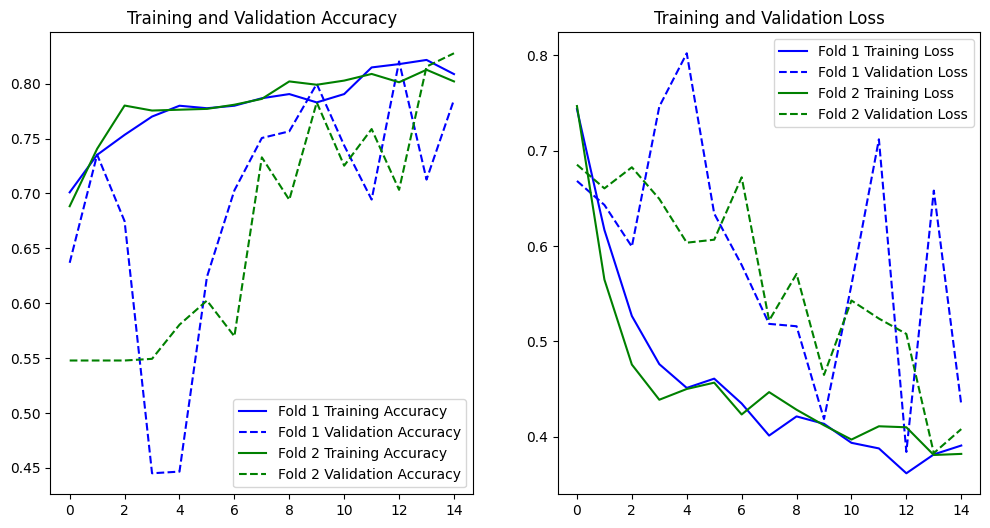

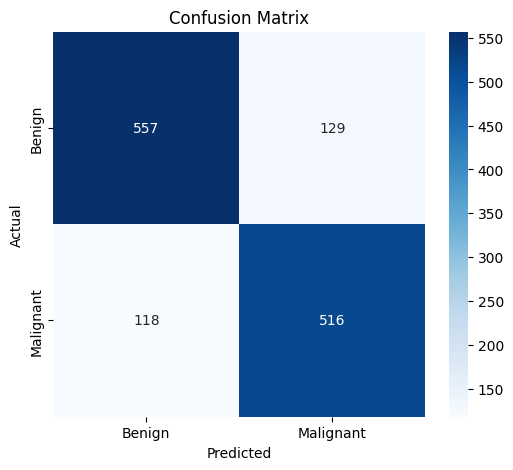

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    batch_size=32, epochs=15,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

### Testing leaky relus with more epochs

#

Epoch 1/40
42/42 [==============================] - 18s 378ms/step - loss: 0.7818 - accuracy: 0.6988 - val_loss: 0.6683 - val_accuracy: 0.5800
Epoch 2/40
42/42 [==============================] - 15s 348ms/step - loss: 0.5498 - accuracy: 0.7618 - val_loss: 0.6270 - val_accuracy: 0.6096
Epoch 3/40
42/42 [==============================] - 15s 345ms/step - loss: 0.4872 - accuracy: 0.7519 - val_loss: 0.6821 - val_accuracy: 0.4905
Epoch 4/40
42/42 [==============================] - 15s 348ms/step - loss: 0.4695 - accuracy: 0.7822 - val_loss: 0.5925 - val_accuracy: 0.7248
Epoch 5/40
42/42 [==============================] - 15s 348ms/step - loss: 0.4598 - accuracy: 0.7663 - val_loss: 0.6012 - val_accuracy: 0.6801
Epoch 6/40
42/42 [==============================] - 14s 342ms/step - loss: 0.4498 - accuracy: 0.7914 - val_loss: 0.5053 - val_accuracy: 0.7392
Epoch 7/40
42/42 [==============================] - 15s 348ms/step - loss: 0.4298 - accuracy: 0.7777 - val_loss: 0.5948 - val_accuracy: 0.6839

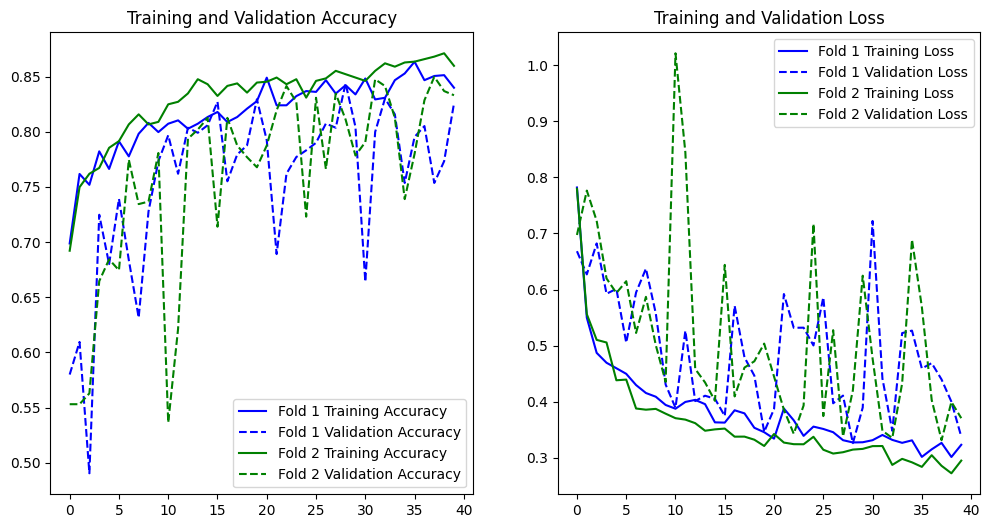

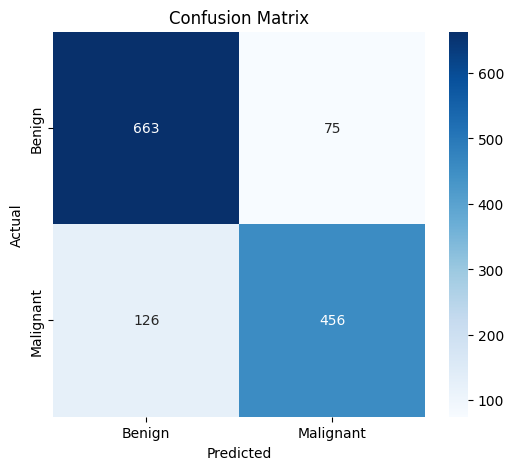

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    batch_size=32, epochs=40,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

#**Evaluation of results**

### Chaning batch size to 64

Epoch 1/40
21/21 [==============================] - 19s 792ms/step - loss: 0.7973 - accuracy: 0.6806 - val_loss: 0.6785 - val_accuracy: 0.5497
Epoch 2/40
21/21 [==============================] - 16s 739ms/step - loss: 0.6204 - accuracy: 0.7405 - val_loss: 0.6593 - val_accuracy: 0.5497
Epoch 3/40
21/21 [==============================] - 15s 729ms/step - loss: 0.5501 - accuracy: 0.7580 - val_loss: 0.6554 - val_accuracy: 0.5504
Epoch 4/40
21/21 [==============================] - 15s 721ms/step - loss: 0.4863 - accuracy: 0.7595 - val_loss: 0.6221 - val_accuracy: 0.5618
Epoch 5/40
21/21 [==============================] - 16s 735ms/step - loss: 0.4694 - accuracy: 0.7868 - val_loss: 0.6325 - val_accuracy: 0.5504
Epoch 6/40
21/21 [==============================] - 15s 735ms/step - loss: 0.4607 - accuracy: 0.7754 - val_loss: 0.5768 - val_accuracy: 0.6270
Epoch 7/40
21/21 [==============================] - 15s 723ms/step - loss: 0.4283 - accuracy: 0.7906 - val_loss: 0.5319 - val_accuracy: 0.7741

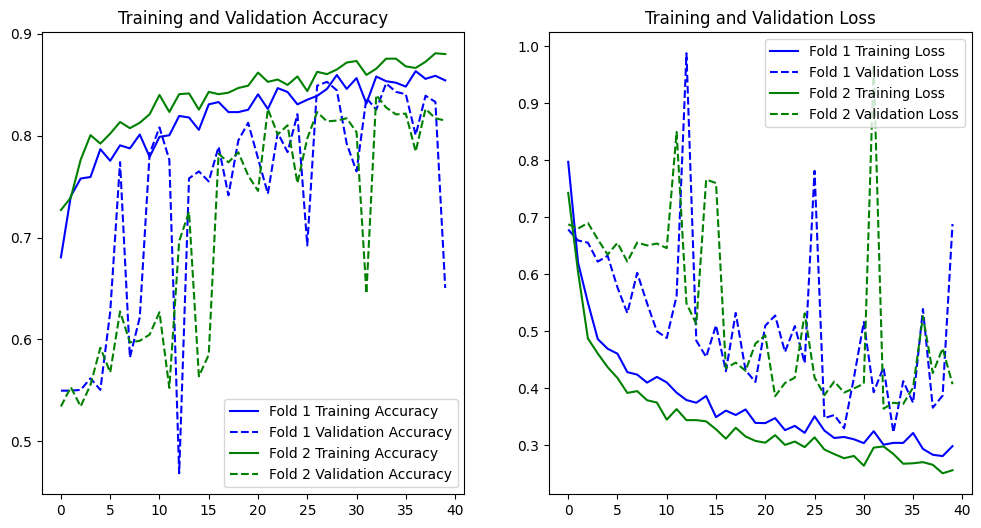

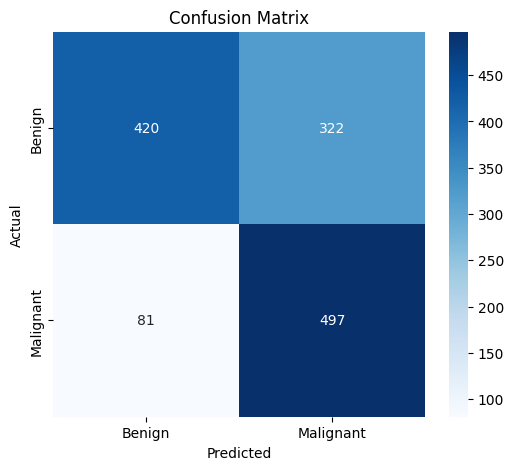

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    batch_size=64, epochs=40,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

### Decreasing batch size to 16, 64 had negative effect


Epoch 1/40
83/83 [==============================] - 18s 189ms/step - loss: 0.7523 - accuracy: 0.6988 - val_loss: 0.7096 - val_accuracy: 0.5451
Epoch 2/40
83/83 [==============================] - 14s 173ms/step - loss: 0.5902 - accuracy: 0.7261 - val_loss: 0.6396 - val_accuracy: 0.6535
Epoch 3/40
83/83 [==============================] - 15s 177ms/step - loss: 0.5065 - accuracy: 0.7481 - val_loss: 0.5962 - val_accuracy: 0.7020
Epoch 4/40
83/83 [==============================] - 15s 175ms/step - loss: 0.4654 - accuracy: 0.7686 - val_loss: 0.5376 - val_accuracy: 0.6596
Epoch 5/40
83/83 [==============================] - 15s 175ms/step - loss: 0.4460 - accuracy: 0.7883 - val_loss: 0.4857 - val_accuracy: 0.7392
Epoch 6/40
83/83 [==============================] - 15s 176ms/step - loss: 0.4214 - accuracy: 0.7792 - val_loss: 0.4066 - val_accuracy: 0.8097
Epoch 7/40
83/83 [==============================] - 14s 174ms/step - loss: 0.4360 - accuracy: 0.7944 - val_loss: 0.4443 - val_accuracy: 0.7756

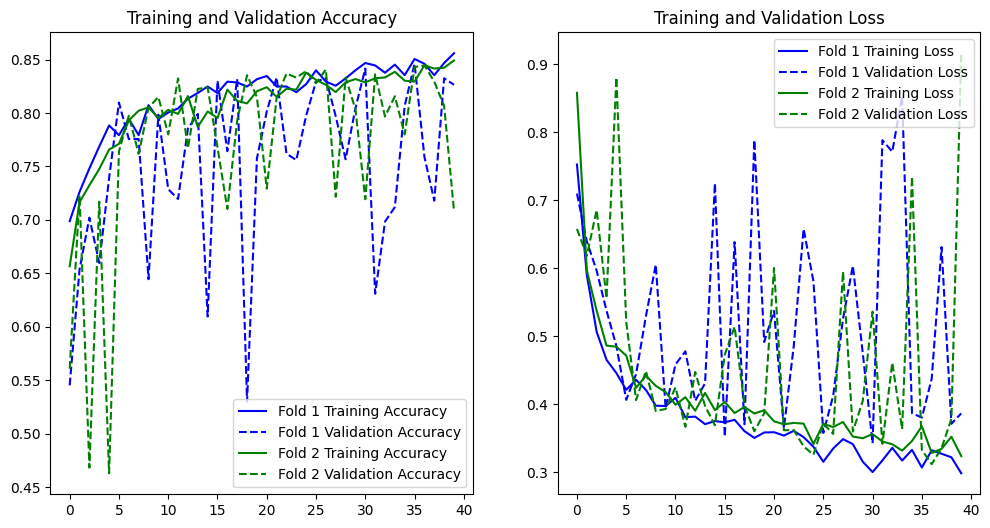

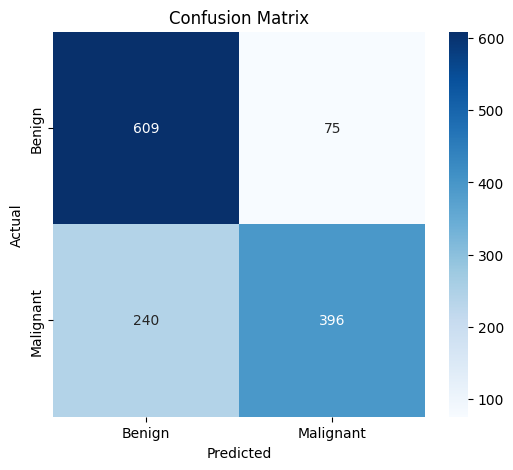

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    batch_size=16, epochs=40,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

### 64 seems to be the optimal batch size

### Adding height/width shift data augmentation

Epoch 1/40
21/21 [==============================] - 18s 786ms/step - loss: 0.7778 - accuracy: 0.7185 - val_loss: 0.6757 - val_accuracy: 0.5368
Epoch 2/40
21/21 [==============================] - 15s 729ms/step - loss: 0.5841 - accuracy: 0.7307 - val_loss: 0.6724 - val_accuracy: 0.5368
Epoch 3/40
21/21 [==============================] - 16s 764ms/step - loss: 0.5056 - accuracy: 0.7656 - val_loss: 0.6471 - val_accuracy: 0.5603
Epoch 4/40
21/21 [==============================] - 16s 748ms/step - loss: 0.5061 - accuracy: 0.7542 - val_loss: 0.6393 - val_accuracy: 0.5534
Epoch 5/40
21/21 [==============================] - 16s 739ms/step - loss: 0.4478 - accuracy: 0.7709 - val_loss: 0.6129 - val_accuracy: 0.6262
Epoch 6/40
21/21 [==============================] - 16s 735ms/step - loss: 0.4331 - accuracy: 0.7800 - val_loss: 0.5897 - val_accuracy: 0.7316
Epoch 7/40
21/21 [==============================] - 16s 735ms/step - loss: 0.4286 - accuracy: 0.7914 - val_loss: 0.5855 - val_accuracy: 0.7597

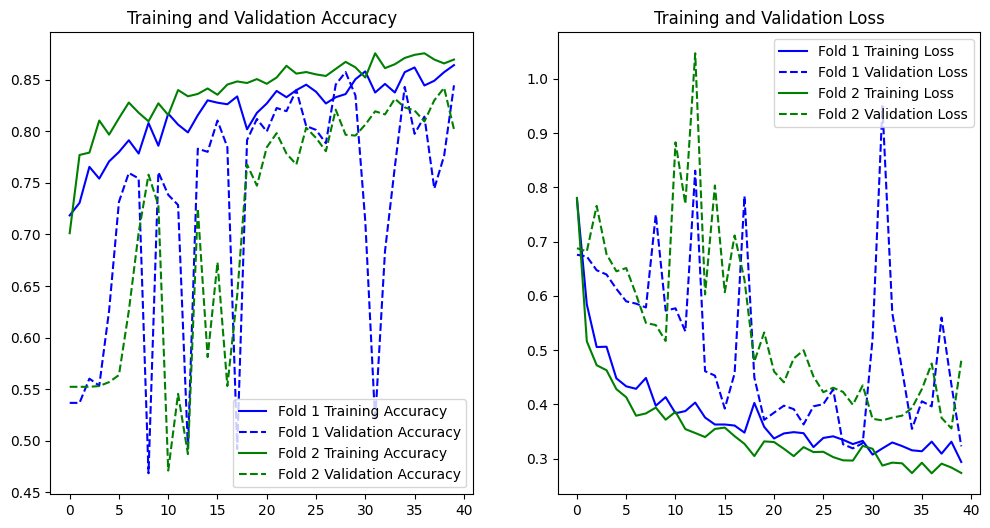

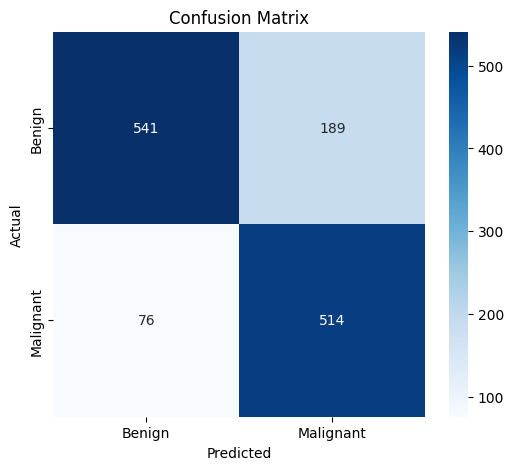

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    batch_size=64, epochs=40,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

### heigh/width shift augmentation did not work

### increasing folds to increase size of dataset due to small size of dataset



In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=(2,2),
    num_folds=5,
    batch_size=64, epochs=20,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

NameError: name 'ImageDataGenerator' is not defined